# Models Notebook

This notebook will contain model iterations and feature experimention/engineering as well as continued EDA. This is a continuation of 02_mc_models notebook.

A few notes I need to keep in mind:
- We are focusing on correctly identifying the failing pumps, as this prevents people from accessing drinking water and is the most important to classify
- Because of this we will be using recall as primary metric. I may need to manually calculate as we are trying to minimize false negatives for specific class in a multiclass problem
- Other questions to explore:
    - Are there areas/regions that have more failing wells?
    - Does water quality appear to contribute to the likelihood of a well failing/needing repair?
    - How is the status of a well associated with the population using the well, if at all?
    - Is there a difference in rates of failure/repair between groundwater and surface water wells?
    - is there a difference in failure/repair with the type of pump?
    - Does the age of the well indicate liklihood of needed repair or failure?

In [2]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Model selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, make_scorer

# Ensemble/XGBoost
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

#.py file
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import src.mc_functions as mcf

# class balancing
from imblearn.over_sampling import SMOTENC

%matplotlib inline

/Users/mattcarr/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


Create standard dataframe from .py file

In [3]:
df = mcf.create_base_df()

In [4]:
df.head()

,status_group,amount_tsh,gps_height,installer,basin,region,population,construction_year,extraction_type_group,management_group,payment,water_quality,quantity,source_type,waterpoint_type_group
0,functional,6000.0,1390,Roman,Lake Nyasa,Iringa,109,1999,gravity,user-group,pay annually,soft,enough,spring,communal standpipe
1,functional,0.0,1399,GRUMETI,Lake Victoria,Mara,280,2010,gravity,user-group,never pay,soft,insufficient,rainwater harvesting,communal standpipe
2,functional,25.0,686,World vision,Pangani,Manyara,250,2009,gravity,user-group,pay per bucket,soft,enough,dam,communal standpipe
3,non functional,0.0,263,UNICEF,Ruvuma / Southern Coast,Mtwara,58,1986,submersible,user-group,never pay,soft,dry,borehole,communal standpipe
4,functional,0.0,0,Artisan,Lake Victoria,Kagera,0,0,gravity,other,never pay,soft,seasonal,rainwater harvesting,communal standpipe


I want to split the data right away and get straight into modeling.

In [5]:
# target
y = df['status_group']
# features
X = df.drop('status_group', axis=1)

In [6]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.2)

Now I can begin experimenting with different models and features. One thing I feel will strongly influence the status of a pump is the age. So I am going to engineer an age column for X_train and X_test. As it stands, construction year is missing a large portion of it's data. To begin, I will fill in the missing values with the median year for it's respective basin. First I need to replace all the 0's in construction year with np.nan so it doesn't mess with the median.

In [7]:
X_train['construction_year'] = X_train['construction_year'].replace(0, np.nan)

Now I can calculate median construction_year for each basin

In [8]:
basins = X_train['basin'].unique()
med_year_basin = {}
for basin in basins:
    med_year = X_train[X_train['basin'] == basin].median()['construction_year']
    med_year_basin[basin] = med_year

I need to replace the np.nan with 0 in X_train construction_year again

In [9]:
X_train['construction_year'] = X_train['construction_year'].replace(np.nan, 0)

In [10]:
# fill in missing construction_year in X_train
for idx, row in X_train.iterrows():
    if row['construction_year'] == 0:
        X_train['construction_year'][idx] = med_year_basin[row['basin']]

In [11]:
# fill in missing construction_year in X_test
for idx, row in X_test.iterrows():
    if row['construction_year'] == 0:
        X_test['construction_year'][idx] = med_year_basin[row['basin']]

Now using the construction_year with filled in values I can create an age column for X_train and X_test

In [12]:
X_train['age'] = 2020 - X_train['construction_year']
X_test['age'] = 2020 - X_test['construction_year']

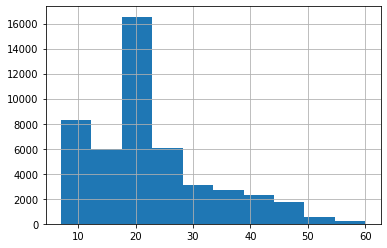

In [13]:
X_train['age'].hist()

Now that I have an age column I can begin testing some different models. I want to start with a RandomForest model to check feature importance and see if any of the current features can be dropped

In [14]:
num_vars = ['amount_tsh', 'gps_height', 'age']
cat_vars = ['basin', 'extraction_type_group', 'management_group', 'payment', 'water_quality', 'quantity', 'source_type', 'waterpoint_type_group']
rf1 = RandomForestClassifier(n_estimators=1000, criterion='entropy', max_depth=7, class_weight='balanced')
model1 = mcf.cross_val_metrics(X_train, X_test, y_train, y_test, rf1, 10, cat_vars, num_vars)

Training Recall: 0.6260802469135802
Val Recall: 0.6206860269360269
Training Recall: 0.626473063973064
Testing Recall: 0.6166666666666667
Training CM:
            Functional  Repair  Failing
Functional       16930    7316     1556
Repair             852    2358      256
Failing           4360    3410    10482
Testing CM:
            Functional  Repair  Failing
Functional        4188    1884      385
Repair             228     556       67
Failing           1140     850     2582


Replace 0 with np.nan for construction_year in df

In [15]:
df['construction_year'] = df['construction_year'].replace(0, np.nan)

In [16]:
df_med_year_basin = {}
for basin in basins:
    med_year = df[df['basin'] == basin].median()['construction_year']
    df_med_year_basin[basin] = med_year

replace np.nan for df construction_year

In [17]:
df['construction_year'] = df['construction_year'].replace(np.nan)

In [18]:
# fill in missing construction_year in df
for idx, row in df.iterrows():
    if row['construction_year'] == 0:
        df['construction_year'][idx] = df_med_year_basin[row['basin']]

In [19]:
df['age'] = 2020 - df['construction_year']

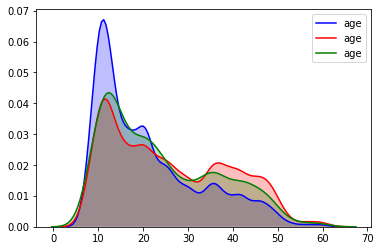

In [20]:
sns.kdeplot(df[df['status_group'] == 'functional']['age'], shade=True, color='blue')
sns.kdeplot(df[df['status_group'] == 'non functional']['age'], shade=True, color='red')
sns.kdeplot(df[df['status_group'] == 'functional needs repair']['age'], shade=True, color='green')

The model class weights didn't work very well. I am going to try smote to oversample the repair status_group class

In [21]:
X_b = X.copy()
y_b = y.copy()

In [22]:
cat_index = []
for idx, col in enumerate(X_train.columns):
    if X_train[col].dtype == 'object':
        cat_index.append(idx)

In [23]:
sm = SMOTENC(cat_index, random_state=42, sampling_strategy='minority')

In [24]:
X_train_b, y_train_b = sm.fit_resample(X_train, y_train)

ValueError: Input contains NaN

The installer column is still missing values. I am going to impute that quick with SimpleImputer and strategy='most_frequent', since I likely will not use it in the model anyways.

In [25]:
impute = SimpleImputer(strategy='most_frequent')

In [26]:
X_train['installer'] = impute.fit_transform(np.array(X_train['installer']).reshape(-1, 1))

In [27]:
X_train_b_array, y_train_b_array = sm.fit_resample(X_train, y_train)

In [28]:
X_train_b = pd.DataFrame(X_train_b_array, columns=X_train.columns)
y_train_b = pd.DataFrame(y_train_b_array, columns=['status_group'])

Great now all of the groups have about the same number of observations. Now I want to create a pretty basic model and compare how the oversampled data performs vs the regular data.

In [29]:
logreg = LogisticRegression(solver='liblinear', random_state=42)

In [30]:
num_vars = ['amount_tsh', 'age']
cat_vars = ['basin', 'extraction_type_group', 'management_group', 'quantity', 'source_type', 'waterpoint_type_group']
unbalanced_model = mcf.cross_val_metrics(X_train, X_test, y_train, y_test, logreg, 10, cat_vars, num_vars)

Training Recall: 0.7117167040778152
Val Recall: 0.711132154882155
Training Recall: 0.7117424242424243
Testing Recall: 0.710942760942761
Training CM:
            Functional  Repair  Failing
Functional       23596       0     2206
Repair            2942       0      524
Failing           8026       0    10226
Testing CM:
            Functional  Repair  Failing
Functional        5913       0      544
Repair             722       0      129
Failing           2039       0     2533


In [31]:
oversampled_model = mcf.cross_val_metrics(X_train_b, X_test, y_train_b, y_test, logreg, 10, cat_vars, num_vars)

Training Recall: 0.6109998257975459
Val Recall: 0.5338105887611198
Training Recall: 0.6067624828218049
Testing Recall: 0.5851010101010101
Training CM:
            Functional  Repair  Failing
Functional       16539    8058     1205
Repair            7406   16828     1568
Failing           4962    4271     9019
Testing CM:
            Functional  Repair  Failing
Functional        4185    1968      304
Repair             262     524       65
Failing           1305    1025     2242


I'm not sure I should just take this one model into account, but it seems like oversampling made the model perform much worse. I am going to test this one more time by using a RandomForest and seeing if I can get some more accurate predictions. I will also use fewer features and try to simplify things.

In [32]:
rf2 = RandomForestClassifier(random_state=42, max_depth=7)
num_vars2 = ['age']
cat_vars2 = ['basin', 'extraction_type_group', 'management_group', 'source_type',]
unbalanced_model2 = mcf.cross_val_metrics(X_train, X_test, y_train, y_test, rf2, 10, cat_vars2, num_vars2)

Training Recall: 0.655702861952862
Val Recall: 0.6530723905723905
Training Recall: 0.6536616161616161
Testing Recall: 0.659006734006734
Training CM:
            Functional  Repair  Failing
Functional       23747       0     2055
Repair            3087       0      379
Failing          10937       0     7315
Testing CM:
            Functional  Repair  Failing
Functional        5969       0      488
Repair             747       0      104
Failing           2712       0     1860


In [33]:
oversampled_model2 = mcf.cross_val_metrics(X_train_b, X_test, y_train_b, y_test, rf2, 10, cat_vars2, num_vars2)

Training Recall: 0.5839680450357099
Val Recall: 0.49127062387378295
Training Recall: 0.5842876775080165
Testing Recall: 0.5037878787878788
Training CM:
            Functional  Repair  Failing
Functional       15712    8970     1120
Repair            5896   19059      847
Failing           6692    5515     6045
Testing CM:
            Functional  Repair  Failing
Functional        3874    2288      295
Repair             228     577       46
Failing           1668    1370     1534


So I think it's same to assume that oversampling was not effect. I want to see if undersampling the majority class would have any better results.

In [34]:
from imblearn.under_sampling import CondensedNearestNeighbour

In [35]:
cnn = CondensedNearestNeighbour(sampling_strategy='not minority', random_state=42)

In [36]:
X_train_u, y_train_u = cnn.fit_resample(X_train, y_train)

ValueError: could not convert string to float: 'DMDD'

I am going to change my overall modeling approach, so I am going to begin a new notebook which again is just a continuation of this one.